Estimating mean and variance for a Gaussian distribution $N(\mu, \sigma^2)$

**Problem**: Given data $\mathcal{D} = \{(y_i)\}$, assuming that these data points were generated by a hidden Gaussian distribution $N(\mu, \sigma^2)$. Estimate its parameters.

**Solution**:

We use a noninformation prior $$p(\mu, \sigma) \propto (\sigma^2)^{-1}$$

Then $$p(\mu,\sigma^2 | y) \propto \sigma^{-n-2}exp(-\frac{1}{2\sigma^2}[(n-1)\sigma^2 + n(\bar{y} - \mu)^2])$$

where $$s^2  = \frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{y})^2$$

is the sample variance of the data $\mathcal{D} = \{(y_i)\}$.

We also have $$\mu|\sigma^2,y \sim N(\bar{y}, \sigma^2/n)$$

and $$\sigma^2|y = Inv\text{-}\chi^2(n-1, \sigma^2)$$

Note that the scaled inverse chi square distribution is not implemented by scipy. So we need to implement ourself. Its formula is as follow:

$$Inv\text{-}\chi^2(\nu, s^2) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}s^{\nu}\theta^{-(\nu/2 + 1)}exp(\frac{-\nu s^2}{2\theta})$$

This is the same as $Inv\text{-}gamma(\alpha=\frac{\nu}{2}, \beta = \frac{\nu}{2}s^2)$

scipy provided this function.

We are normally interested in the mean $\mu$. Hence, we want to compute the marginal posterior distribution of $\mu$: $$p(\mu|y) = \int_{0}^{\infty}p(\mu, \sigma^2|y)d\sigma^2$$

Note that we normally do not compute the above integration. But in this case, we do have a closed form for this integration. In case of no closed form availability, we perform sampling. 

The closed form is as follows $$\frac{\mu - \bar{y}}{s/\sqrt{n}}\big|y \sim t_{n-1}$$, where $t_{n-1}$ denotes the standard (Student) t density (location = 0, scale = 1), with n-1 degrees of freedom.

In the above discussion, we have closed forms for all probabilities. In general case, we do not have. We resolve to simulation. In the following code we will use this approach.

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.curdir, '../utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [4]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the sample estimate
my = np.mean(y)

In [5]:
# set random number generator with seed
rng = np.random.RandomState(seed=0)

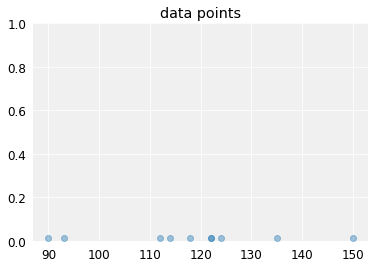

In [6]:
plt.plot(y, np.ones_like(y)/80, 'o', alpha=0.4)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('data points');

In [7]:
# factorize the joint posterior p(mu,sigma2|y) to p(sigma2|y)p(mu|sigma2,y)
# sample from the joint posterior using this factorization

# sample from p(sigma2|y)
sigma2 = sinvchi2.rvs(n-1, s2, size=1000, random_state=rng)
# sample from p(mu|sigma2,y)
# student-t dist is replaced by standard normal
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)
# display sigma instead of sigma2
sigma = np.sqrt(sigma2)
# sample from the predictive distribution p(ynew|y)
# for each sample of (mu, sigma)
ynew = rng.randn(*mu.shape)*sigma + mu

To understand the sampling of mu. Note that:

$$\mu|\sigma^2,y \sim N(\bar{\mu}, \sigma^2/n)$$ which means

$$\mu = \bar{y} + \frac{\sigma}{\sqrt{n}}X,$$ where $X \sim \cal{N}(0,1)$

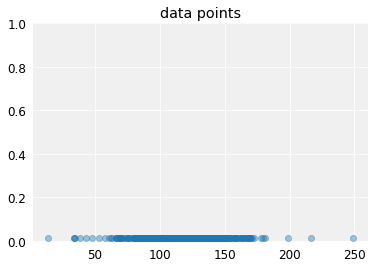

In [8]:
plt.plot(ynew, np.ones_like(ynew)/80, 'o', alpha=0.4)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('data points');

In [9]:
# for mu compute the density in these points
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)
# for sigma compute the density in these points
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)
# for ynew compute the density in these points
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

# evaluate the joint density in a grid
# note that the following is not normalized, but for plotting
# contours it does not matter
Z = stats.norm.pdf(t1, my, t2[:,np.newaxis]/np.sqrt(n))
Z *= (sinvchi2.pdf(t2**2, n-1, s2)*2*t2)[:,np.newaxis]

# compute the exact marginal density for mu
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# z=(x-mean(y))/sqrt(s2/n), see BDA3 p. 21
pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)

# estimate the marginal density for mu using samples and an ad hoc Gaussian
# kernel approximation
pk_mu = stats.gaussian_kde(mu).evaluate(t1)

# compute the exact marginal density for sigma
# multiplication by 2*t2 is due to the transformation of variable
# z=t2^2, see BDA3 p. 21
pm_sigma = sinvchi2.pdf(t2**2, n-1, s2)*2*t2
# N.B. this was already calculated in the joint distribution case

# estimate the marginal density for sigma using samples and an ad hoc Gaussian
# kernel approximation
pk_sigma = stats.gaussian_kde(sigma).evaluate(t2)

# compute the exact predictive density
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# see BDA3 p. 21
p_new = stats.t.pdf((xynew-my)/np.sqrt(s2*(1+1/n)), n-1) / np.sqrt(s2*(1+1/n))

Joint and marginal posterior distributions


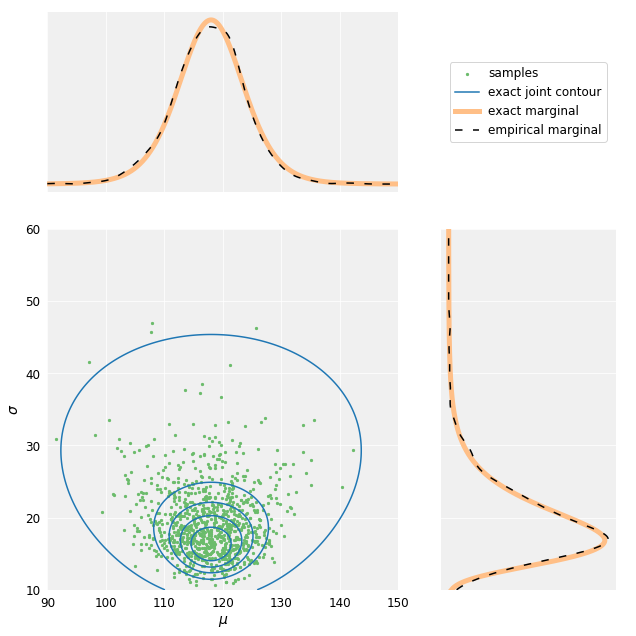

In [10]:
print('Joint and marginal posterior distributions')

# create figure
fig, axes = plt.subplots(
    2, 2,
    figsize=(9, 9),
    gridspec_kw=dict(
        width_ratios=[2, 1],
        height_ratios=[1, 2]
    )
)

# plot the joint distribution
ax = axes[1, 0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize='14')
ax.set_ylabel('$\sigma$', fontsize='14')

# plot the marginal of mu
ax = axes[0, 0]
# exact
ax.plot(
    t1,
    pm_mu,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
ax.plot(
    t1,
    pk_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_xlim(tl1)
ax.set_yticks(())
ax.set_xticklabels(())

# plot the marginal of sigma
ax = axes[1, 1]
# exact
exact_line, = ax.plot(
    pm_sigma,
    t2,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
empirical_line, = ax.plot(
    pk_sigma,
    t2,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_ylim(tl2)
ax.set_xticks(())
ax.set_yticklabels(())

# hide last ax
ax = axes[0, 1]
ax.axis('off')
# make legend there
ax.legend(
    (
        samps,
        plt.Line2D([], [], color='C0'),
        exact_line,
        empirical_line
    ),
    (
        'samples',
        'exact joint contour',
        'exact marginal',
        'empirical marginal'
    ),
    loc='center',
)

fig.tight_layout()

Visualise factored sampling and the corresponding marginal and conditional densities.

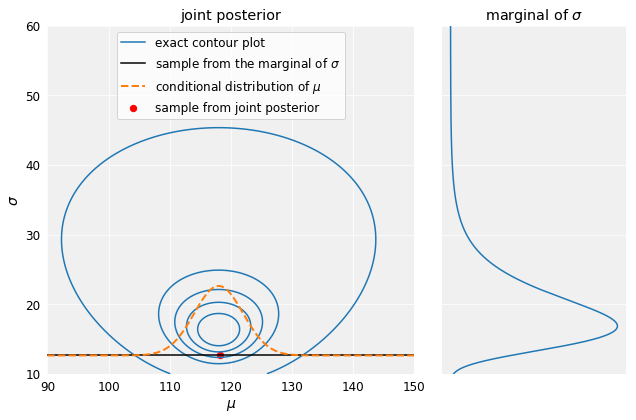

In [11]:
# create figure
fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# plot the joint distribution
ax = axes[0]
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')

# plot the first sample
line1, = ax.plot(tl1, [sigma[0], sigma[0]], 'k')
line2, = ax.plot(
    t1,
    sigma[0] + stats.norm.pdf(t1, my, np.sqrt(sigma2[0]/n))*100,
    color='C1',
    linestyle='dashed',
    linewidth=2
)
scat = ax.scatter(mu[0], sigma[0], 40, color='r')

# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_title('joint posterior')
ax.legend(
    (plt.Line2D([], [], color='C0'), line1, line2, scat),
    ('exact contour plot',
     'sample from the marginal of $\\sigma$',
     'conditional distribution of $\\mu$',
     'sample from joint posterior'),
    loc='upper center'
)

# plot the marginal of sigma
ax = axes[1]
ax.plot(pm_sigma, t2)
# decorate
ax.set_ylim(tl2)
ax.set_title('marginal of $\sigma$')
ax.set_xticks(());
ax.set_yticklabels(())

fig.tight_layout()

Visualise the marginal distribution of mu as a mixture of normals.

In [126]:
np.mean(y)

118.0

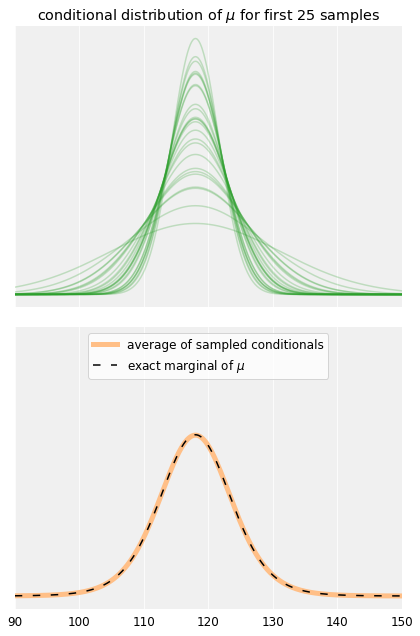

In [122]:
# calculate conditional pdfs for each sample
condpdfs = stats.norm.pdf(t1, my, np.sqrt(sigma2/n)[:,np.newaxis])

# create figure
fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# plot some of them
ax = axes[0]
ax.plot(t1, condpdfs[:25].T, 'C2', alpha=0.25)
ax.set_xlim(tl1)
ylims_from_0 = ax.set_ylim()  # set same y_lims to the next plot
ax.set_title('conditional distribution of $\\mu$ for first 25 samples')
ax.set_yticks(())

# plot their mean
ax = axes[1]
ax.plot(
    t1,
    np.mean(condpdfs, axis=0),
    color=plot_tools.lighten('C1'),
    linewidth=5,
    label='average of sampled conditionals'
)
ax.plot(
    t1,
    pm_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5,
    label='exact marginal of $\\mu$'
)
ax.set_yticks(())
ax.set_xlim(tl1)
ax.set_ylim(ylims_from_0)
ax.legend(loc='upper center')

fig.tight_layout()

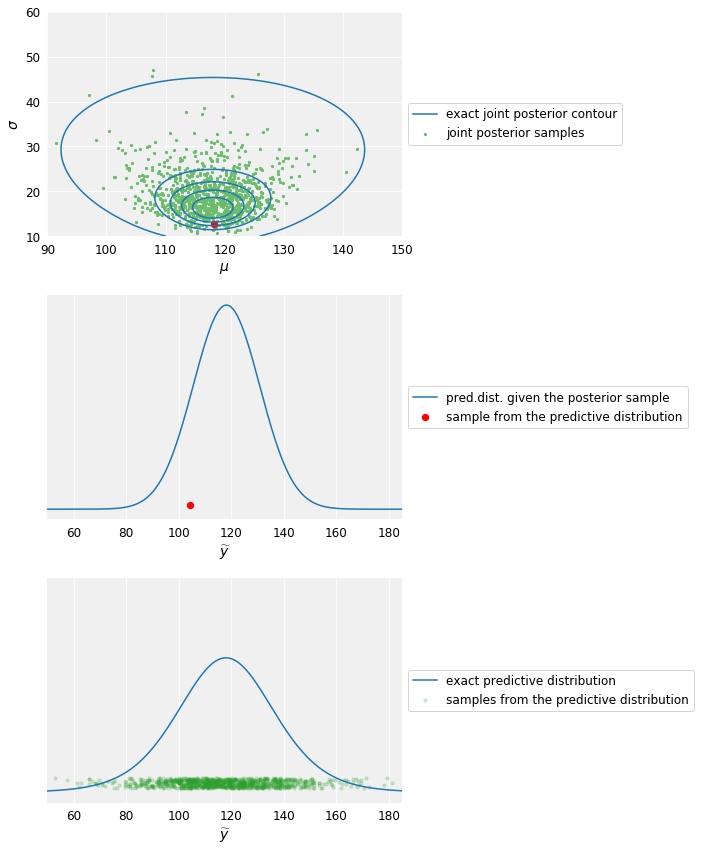

In [133]:
# calculate predictive pdf for the first given mu and sigma sample
ynewdists = stats.norm.pdf(xynew, mu[0], sigma[0])

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# plot the joint distribution
ax = axes[0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.legend(
    (plt.Line2D([], [], color='C0'), samps),
    ('exact joint posterior contour', 'joint posterior samples'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
# highlight the first sample
ax.scatter(mu[0], sigma[0], 40, 'r')

# plot first ynew
ax = axes[1]
# plot the distribution and the respective sample
line1, = ax.plot(xynew, ynewdists)
ax1_hs = ax.scatter(ynew[0], 0.02*np.max(ynewdists), 40, 'r')
# decorate
ylims_from_1 = ax.set_ylim()
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(
    (line1, ax1_hs),
    ('pred.dist. given the posterior sample',
    'sample from the predictive distribution'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# plot all ynews
ax = axes[2]
ax.scatter(
    ynew,
    (0.02 + 0.05*rng.rand(*ynew.shape))*np.max(ynewdists),
    10,
    color='C2',
    alpha=0.2,
    label='samples from the predictive distribution'
)
ax.plot(
    xynew,
    p_new,
    linewidth=1.5,
    label='exact predictive distribution'
)
ax.set_ylim(ylims_from_1)
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

In [132]:
ax.set_ylim?